# Mainstream bigrams

### Imports

In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, FloatType

import string
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt
import random

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[18]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

In [5]:
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("count", IntegerType(), True),
    StructField("bigram_percent", DoubleType(), True),
    StructField("medianA",  DoubleType(), True),
    StructField("ntileA", IntegerType(), True),
    StructField("medianB",  DoubleType(), True),
    StructField("ntileB", IntegerType(), True),
    StructField("label", IntegerType(), True),
    StructField("start_of_mainstreaming", IntegerType(), True),
    StructField("end_of_mainstreaming", IntegerType(), True),
    StructField("peak_year", IntegerType(), True)])

### Load

In [6]:
df_load = spark.read.option('header', False).schema(schema)\
                     .csv('/data/shared1/cleandata/changepoint_annotated_allntiles_newer')

In [5]:
# Only take the mainstream bigrams
df = df_load.where(col('label')==1)

In [6]:
# Only take the not mainstream bigrams
df0 = df_load.where(col('label')==0)

### Inspect all cleaned data

In [7]:
# Make a column with the decades
df_load = df_load.withColumn('peak_decade', when(col("peak_year") < 1910, '1900-1909')\
             .when(col("peak_year") < 1920, "1910-1919")\
             .when(col("peak_year") < 1930, "1920-1929")\
             .when(col("peak_year") < 1940, "1930-1939")\
             .when(col("peak_year") < 1950, "1940-1949")\
             .when(col("peak_year") < 1960, "1950-1959")\
             .when(col("peak_year") < 1970, "1960-1969")\
             .when(col("peak_year") < 1980, "1970-1979")\
             .when(col("peak_year") < 1990, "1980-1989")\
             .when(col("peak_year") < 2000, "1990-1999")\
             .when(col("peak_year") < 2010, "2000-2009")\
             .when(col("peak_year") < 2020, "2010-2019")\
             .otherwise("Unknown"))

In [8]:
df_alldistinct = df_load.select(col('bigram'), col('peak_year'), col('peak_decade')).distinct()

In [8]:
df_alldistinct_pd = df_alldistinct.toPandas()

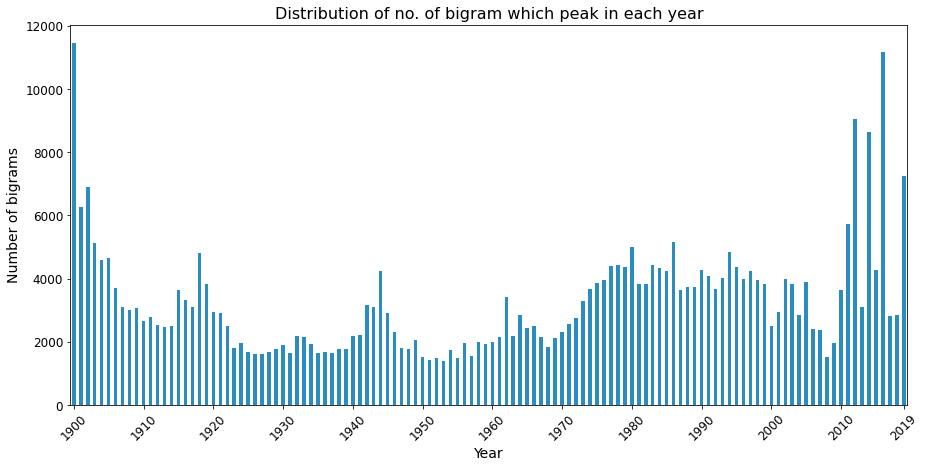

In [59]:
df_alldistinct_pd['peak_year'].value_counts().plot(kind='bar', figsize=(15,7), color='#2b8cbe')
plt.xticks([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2019],rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Number of bigrams", fontsize = 14)
plt.title("Distribution of no. of bigram which peak in each year", fontsize = 16)
plt.savefig('DistributionPeaks',bbox_inches='tight')
plt.show()

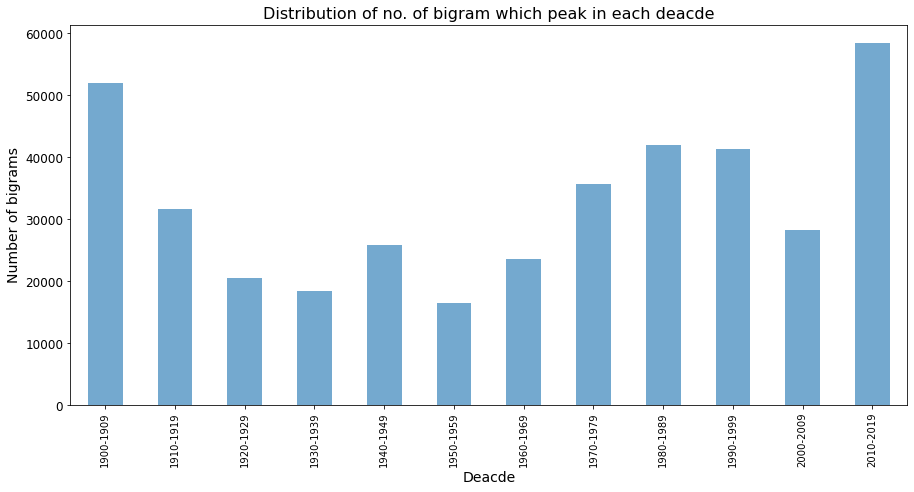

In [58]:
df_alldistinct_pd['peak_decade'].value_counts().sort_index().plot(kind='bar', figsize=(15,7), color='#74a9cf')
plt.yticks(fontsize=12)
plt.xlabel("Deacde", fontsize = 14)
plt.ylabel("Number of bigrams", fontsize = 14)
plt.title("Distribution of no. of bigram which peak in each deacde", fontsize = 16)
plt.savefig('DistributionDeacdePeaks',bbox_inches='tight')
plt.show()

### Max percentage

In [9]:
dfgrouped = df_load.groupBy('bigram').agg(collect_list('bigram_percent').alias('percentages'))

In [10]:
dfgrouped = dfgrouped.withColumn('maxPercent', F.array_max('percentages'))

In [12]:
df_new = df_load.join(dfgrouped.select('bigram','maxPercent'),['bigram'],how='inner')

In [13]:
df_new = df_new.select(col('bigram'),col('peak_decade'),col('maxPercent')).distinct()

In [14]:
df_newGroup = df_new.groupBy('peak_decade').agg(F.mean('maxPercent').alias('meanMax'))

In [31]:
test = df_new_pd.pivot(columns='peak_decade', values='maxPercent')

In [15]:
median_udf = udf(lambda x: float(np.median(x)), FloatType())
dfgrouped2 = df_new.groupBy('peak_decade').agg(collect_list('maxPercent').alias('percentages'))

In [19]:
dfgrouped2_pd = dfgrouped2.toPandas()

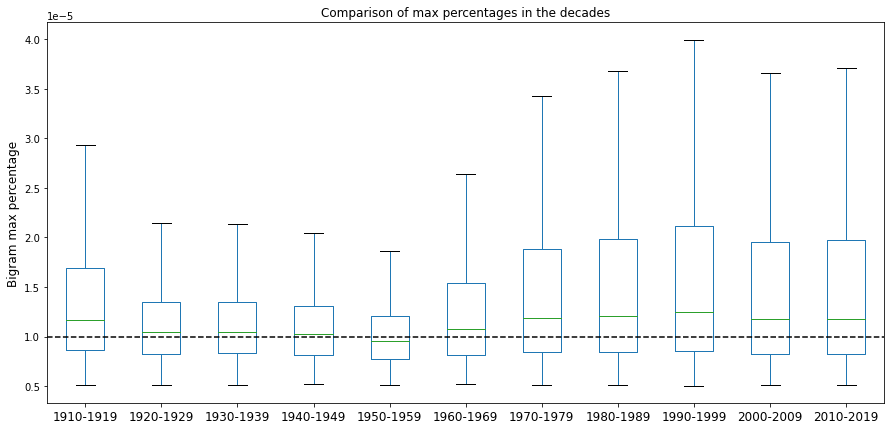

In [44]:
df_new_pd = df_new.toPandas()
test[['1910-1919','1920-1929','1930-1939','1940-1949','1950-1959', '1960-1969',
      '1970-1979','1980-1989','1990-1999', '2000-2009','2010-2019']].plot.box(figsize=(15,7), sym='')
plt.axhline(y=1e-5,color='black',linestyle='--')
plt.title('Comparison of max percentages in the decades', fontsize=12)
plt.ylabel('Bigram max percentage', fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('maxpercent_boxplot_no_outliers', bbox_inches = 'tight')
plt.show()

In [69]:
df_newGroup2 = dfgrouped2.withColumn('median',median_udf('percentages'))

In [73]:
plotmedian = df_newGroup2.orderBy('peak_decade')

In [75]:
plotmedian_pd = plotmedian.toPandas()

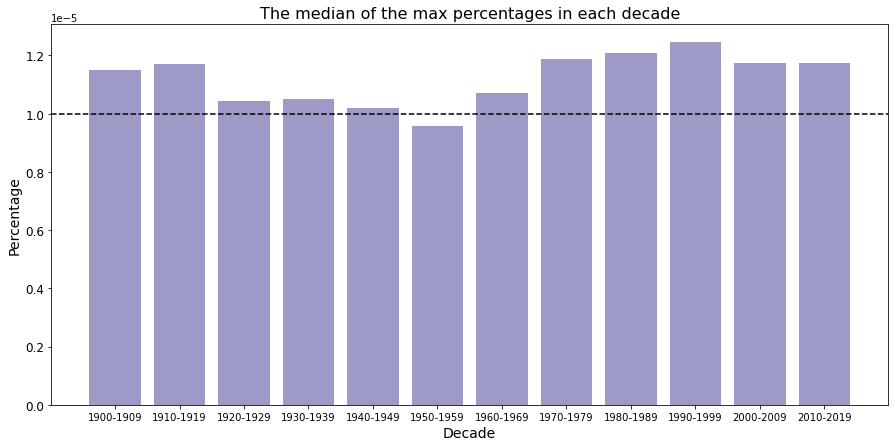

In [120]:
ax, fig = plt.subplots(figsize=(15,7))                
plt.bar(list(plotmedian_pd.peak_decade), list(plotmedian_pd['median']),color='#9e9ac8')
plt.axhline(y=1e-5,color='black',linestyle='--')
plt.yticks(fontsize=12)
plt.xlabel("Decade", fontsize = 14)
plt.ylabel("Percentage", fontsize = 14)
plt.title("The median of the max percentages in each decade", fontsize = 16)
plt.savefig('MedianMaxPercent',bbox_inches='tight')
plt.show()

### Counts

In [5]:
# The number of bigrams in total
df_load.select('bigram').distinct().count()

393834

In [40]:
# The number of not mainstream bigrams
df0.select(col('bigram')).distinct().count()

308926

### Add decades

In [9]:
# Make a column with the decades
df = df.withColumn('peak_decade', when(col("peak_year") < 1910, '1900-1909')\
             .when(col("peak_year") < 1920, "1910-1919")\
             .when(col("peak_year") < 1930, "1920-1929")\
             .when(col("peak_year") < 1940, "1930-1939")\
             .when(col("peak_year") < 1950, "1940-1949")\
             .when(col("peak_year") < 1960, "1950-1959")\
             .when(col("peak_year") < 1970, "1960-1969")\
             .when(col("peak_year") < 1980, "1970-1979")\
             .when(col("peak_year") < 1990, "1980-1989")\
             .when(col("peak_year") < 2000, "1990-1999")\
             .when(col("peak_year") < 2010, "2000-2009")\
             .when(col("peak_year") < 2020, "2010-2019")\
             .otherwise("Unknown"))

### Distinct Bigrams list

In [10]:
# Get the distinct Bigrams
distinctBigrams = df.select(col('bigram'), col('peak_decade'), col('start_of_mainstreaming')).distinct()

In [11]:
decades = distinctBigrams.groupBy(col('peak_decade')).agg(count('*'))

In [36]:
# The number of mainstream bigrams
distinctBigrams.count()

84908

In [13]:
# Make a list of the bigrams and a list with the mainstreaming start year
distinctBigramsList = [str(row.bigram) for row in distinctBigrams.select('bigram').collect()]
mainstreamStartList = [str(row.start_of_mainstreaming) for row in distinctBigrams.select('start_of_mainstreaming').collect()]

### Collect data

In [14]:
# collect data to np arrays
dfgrouped = df.groupBy('bigram').agg(collect_list('bigram_percent').alias('percentages'),
                              collect_list('count').alias('counts'))

dfgrouped = dfgrouped.withColumn('peak', F.array_max('percentages'))

signal = np.array(dfgrouped.select('percentages').collect())
counts = np.array(dfgrouped.select('counts').collect())
peaks = np.array(dfgrouped.select('peak').collect())
bigrams = np.array(dfgrouped.select('bigram').collect())

signal_flat = np.zeros((len(signal), 120))
counts_flat = np.zeros((len(counts), 120))
peaks_flat = np.zeros((len(peaks), 120))
bigrams_flat = []

for i in range(len(signal)):
    signal_flat[i] = signal[i][0]
    counts_flat[i] = counts[i][0]
    peaks_flat[i] = peaks[i][0]
    bigrams_flat.append(bigrams[i][0])

In [15]:
peakDict = dict() # dict containing bigram as key and peaks as values
countDict = dict() # dict containing bigram as key and count in peak as values

for i in range(0, len(signal_flat)):
    peakDict[bigrams_flat[i]] = (np.where(signal_flat[i] == peaks[i])[0][0],peaks[i][0])
    countDict[bigrams_flat[i]] = counts_flat[i][peakDict[bigrams_flat[i]][0]]

In [16]:
# Create Pyspark dataframe

countList= list(zip(list(map(str,countDict.keys())),mainstreamStartList,list(map(float,countDict.values()))))

# create pyspark dataframe with the mainstreaming breakpoint and end of mainstreaming
schema1 = StructType([
    StructField("bigram", StringType(), True),
    StructField("mainstream_start", StringType(), True),
    StructField("maxcount", FloatType(), True)])

maxcountdf = spark.createDataFrame(countList, schema1)

### Join the maxcount to the dataframe

In [17]:
df = df.join(maxcountdf.select('bigram','maxcount'),['bigram'],how='inner')

### Add peak speed to the dataframe

In [18]:
# Create two new columns in the distinct set
df = df.withColumn('years_to_peak', col('peak_year')-col('start_of_mainstreaming'))
df = df.withColumn('peak_speed', F.when(col('years_to_peak') < 5, 'VeryFast')\
                                    .when(col('years_to_peak') < 10, 'Fast')\
                                    .when(col('years_to_peak') < 15, 'Medium')\
                                    .when(col('years_to_peak') < 20, 'Slow')\
                                    .otherwise('VerySlow'))

### Wordcouds for the speed of mainstreaming

In [19]:
# Get a single row for each bigram
df_distinct = df.select(
    'bigram', 'ntileA', 'ntileB','label', 'start_of_mainstreaming', 'end_of_mainstreaming', 'peak_year', 
    'maxcount', 'peak_decade','years_to_peak','peak_speed').distinct()

In [20]:
# How many bigrams is there in the five groups
peak_speed = df_distinct.groupBy('peak_speed').agg(F.count('*').alias('count'))
peak_speed

+----------+-----+
|peak_speed|count|
+----------+-----+
|      Fast|13225|
|    Medium|14740|
|  VerySlow|39436|
|  VeryFast| 4350|
|      Slow|13157|
+----------+-----+

### The 20 mainstream bigrams with largest and smallest max percent

In [22]:
maxPercent = df.groupby('bigram').agg(F.max("bigram_percent").alias('maxPercent'))

In [75]:
largestsmallestMax = df_distinct.join(maxPercent.select('bigram','maxPercent'), ['bigram'], how='inner')

In [76]:
largestsmallestMax.select('bigram','maxPercent','peak_year').sort('maxPercent', ascending=True).show(truncate=False)

+------------------------------+-------------+---------+
|bigram                        |maxPercent   |peak_year|
+------------------------------+-------------+---------+
|opinion_noun concurring_noun  |1.0000096E-5 |1982     |
|soybean_noun seeds_noun       |1.0000096E-5 |1982     |
|negligible_adj importance_noun|1.0000163E-5 |1931     |
|type_adj equipment_noun       |1.0000179E-5 |1957     |
|derek_noun jeter_noun         |1.0000415E-5 |2015     |
|neck_noun cancers_noun        |1.0000415E-5 |2015     |
|natural_adj wetlands_noun     |1.0000469E-5 |1992     |
|japanese_adj model_noun       |1.00006555E-5|1995     |
|face_noun pale_noun           |1.0000681E-5 |2014     |
|near_adj perfect_adj          |1.0000681E-5 |2014     |
|dangerous_adj men_noun        |1.0000681E-5 |2014     |
|response_noun planning_noun   |1.0000883E-5 |1979     |
|significant_adj sex_noun      |1.0000883E-5 |1979     |
|injection_noun lasers_noun    |1.0000978E-5 |1980     |
|eluting_adj stent_noun        

In [77]:
largestsmallestMax.select('bigram','maxPercent','peak_year').sort('maxPercent', ascending=False).show(truncate=False)

+----------------------------+------------+---------+
|bigram                      |maxPercent  |peak_year|
+----------------------------+------------+---------+
|social_adj media_noun       |0.0021112587|2019     |
|dialog_noun box_noun        |0.00149752  |2010     |
|first_noun use_noun         |0.0010611805|2002     |
|cell_noun phone_noun        |0.0010555781|2014     |
|african_adj american_adj    |9.763338E-4 |2009     |
|wide_adj web_noun           |8.755347E-4 |1997     |
|operating_noun system_noun  |8.507288E-4 |1989     |
|web_noun sites_noun         |8.373959E-4 |2001     |
|african_noun americans_noun |8.2375197E-4|2005     |
|p_noun refs_noun            |7.5382943E-4|1970     |
|gulf_noun war_noun          |7.3604635E-4|1991     |
|fcc_noun rcd_noun           |7.206127E-4 |2003     |
|impact_noun statement_noun  |7.069457E-4 |1977     |
|supply_noun chain_noun      |6.821858E-4 |2016     |
|l_noun ord_noun             |6.578229E-4 |2017     |
|google_noun map_noun       

### Wordclouds of the speed of mainstreaming

In [26]:
wordclouddata1 = df_distinct_pd.groupby(['peak_speed'])['bigram'].apply(list).reset_index(name='bigramlist')
wordclouddata2 = df_distinct_pd.groupby(['peak_speed'])['maxcount'].apply(list).reset_index(name='countlist')

In [27]:
# remove POS tags

for i in range(0, len(wordclouddata1)):
    tmp = wordclouddata1['bigramlist'][i]
    tmp = [s.replace('_adj', '') for s in tmp]
    tmp = [s.replace('_noun', '') for s in tmp]
    tmp = [s.replace(' ', '_') for s in tmp]
    wordclouddata1['bigramlist'][i] = tmp

In [28]:
# generate dictionary containing years as keys and all bigrams that start mainstreaming period in given year
# as vals
corpus = dict()

for i in range(0,len(wordclouddata1)):
    ngramlist = wordclouddata1['bigramlist'][i]
    val = wordclouddata2['countlist'][i]
    for j in range(0, len(val)):
        ngramlist.extend([ngramlist[j]]*int(val[j]))
        corpus[i] = ngramlist

In [29]:
# remove , from corpus, creating one long string that wordcloud can read 

corpus_new = dict() # the ngrams

for i in range(0,len(wordclouddata1)):
    ngrams = ''
    ngrams += " ".join(corpus[i])#+" "
    corpus_new[i] =  ngrams

In [34]:
def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(140, 30%%, %d%%)" % random.randint(20, 70)

In [35]:
def purple_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(270, 20%%, %d%%)" % random.randint(20, 70)

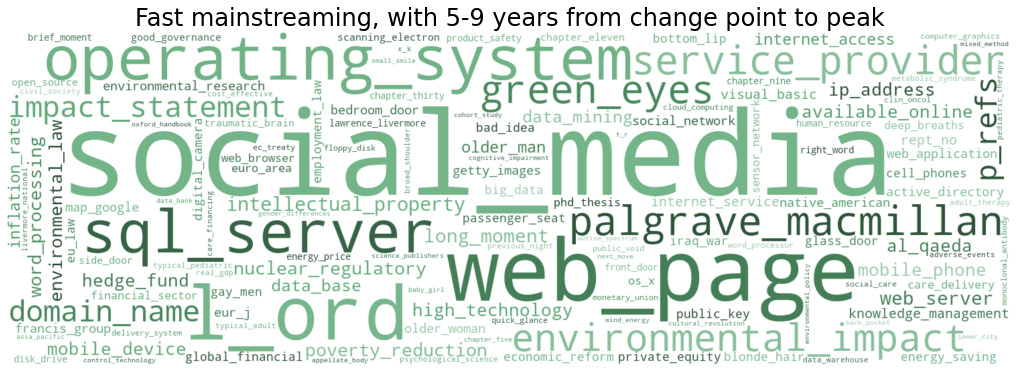

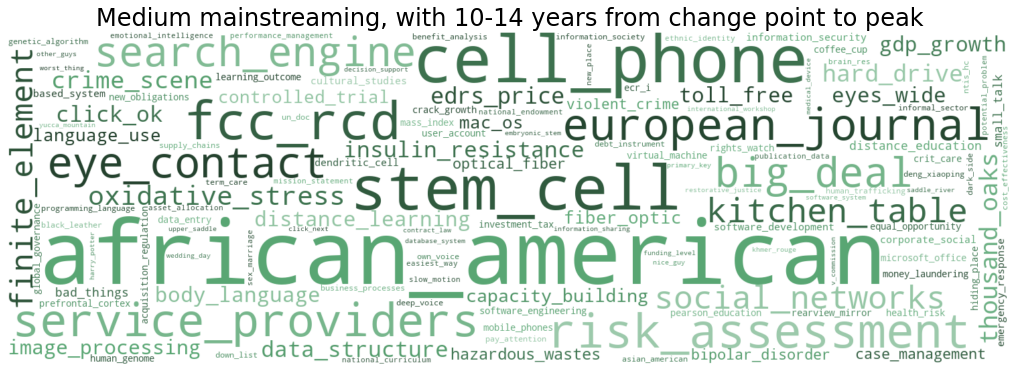

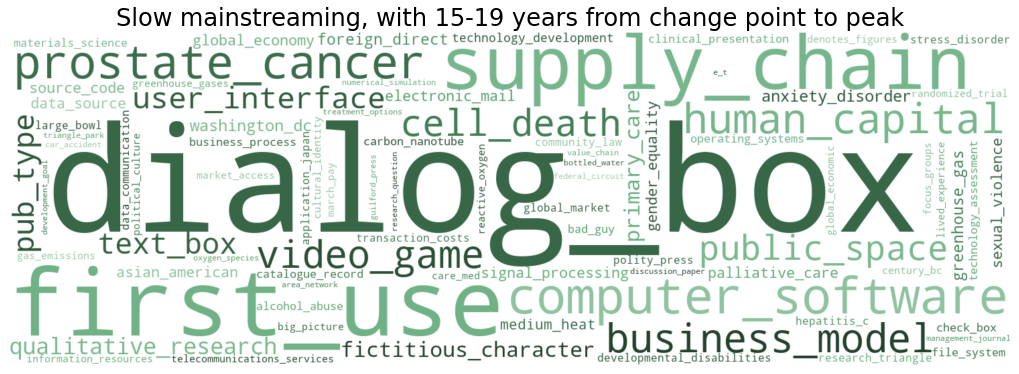

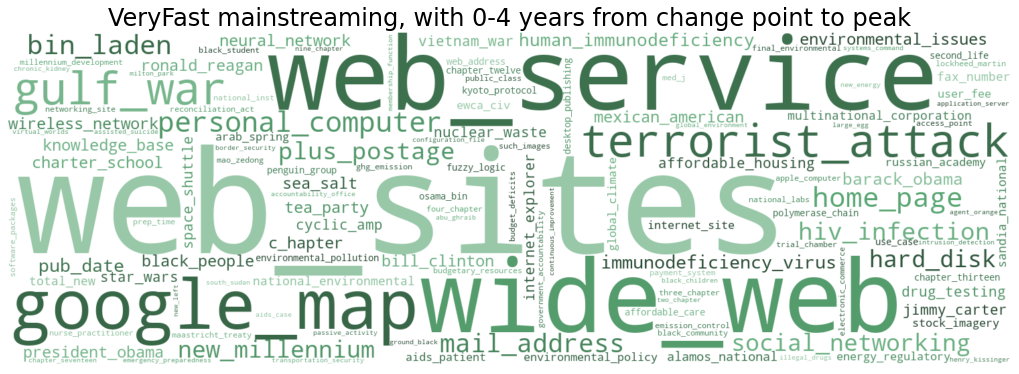

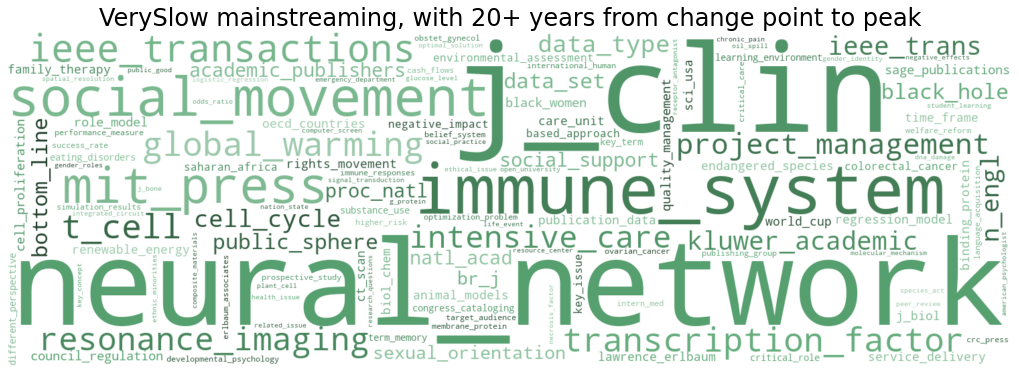

In [36]:
# generate and plot wordclouds
years = ['5-9', '10-14', '15-19', '0-4', '20+']

for i in range(0,5):
    wordcloud = WordCloud(width = 1500, height = 500, background_color ='white', min_font_size = 10, collocations = False).generate(corpus_new[i])

    plt.figure(figsize = (15,5), facecolor = None)
    plt.title(wordclouddata1['peak_speed'][i] + ' mainstreaming, with ' + years[i] 
              + ' years from change point to peak', fontsize=24)
    plt.imshow(wordcloud.recolor(color_func=green_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.savefig('NewSpeedWordcloud' + str(i),bbox_inches='tight')
    plt.show()

### Wordcloud for decades

In [37]:
wordclouddata3 = df_distinct_pd.groupby(['peak_decade'])['bigram'].apply(list).reset_index(name='bigramlist')
wordclouddata4 = df_distinct_pd.groupby(['peak_decade'])['maxcount'].apply(list).reset_index(name='countlist')

In [38]:
wordclouddata3

peak_decade                                         bigramlist
0    1910-1919  [big_adj industries_noun, tungsten_noun filame...
1    1920-1929  [chemical_noun equipment_noun, gold_noun franc...
2    1930-1939  [complete_adj reversal_noun, industry_noun by_...
3    1940-1949  [county_noun agencies_noun, practical_adj prog...
4    1950-1959  [service_noun technician_noun, sincere_adj bel...
5    1960-1969  [airline_noun passengers_noun, better_adj soci...
6    1970-1979  [added_adj tax_noun, additional_adj question_n...
7    1980-1989  [a_noun lot_noun, administration_noun institut...
8    1990-1999  [academic_noun health_noun, amendment_noun vio...
9    2000-2009  [asian_noun region_noun, bank_noun economic_no...
10   2010-2019  [acidic_adj ph_noun, address_noun bar_noun, an...

In [39]:
# remove POS tags

for i in range(0, len(wordclouddata3)):
    tmp = wordclouddata3['bigramlist'][i]
    tmp = [s.replace('_adj', '') for s in tmp]
    tmp = [s.replace('_noun', '') for s in tmp]
    tmp = [s.replace(' ', '_') for s in tmp]
    wordclouddata3['bigramlist'][i] = tmp

In [40]:
corpus = dict()

for i in range(0,len(wordclouddata3)):
    ngramlist = wordclouddata3['bigramlist'][i]
    val = wordclouddata4['countlist'][i]
    for j in range(0, len(val)):
        ngramlist.extend([ngramlist[j]]*int(val[j]))
        corpus[i] = ngramlist

In [41]:
corpus_new = dict() # the ngrams
names= dict()

for i in range(0,len(wordclouddata3)):
    ngram = ''
    ngram += " ".join(corpus[i])+" "
    corpus_new[i] =  ngram
    names[i] = wordclouddata3.peak_decade[i]

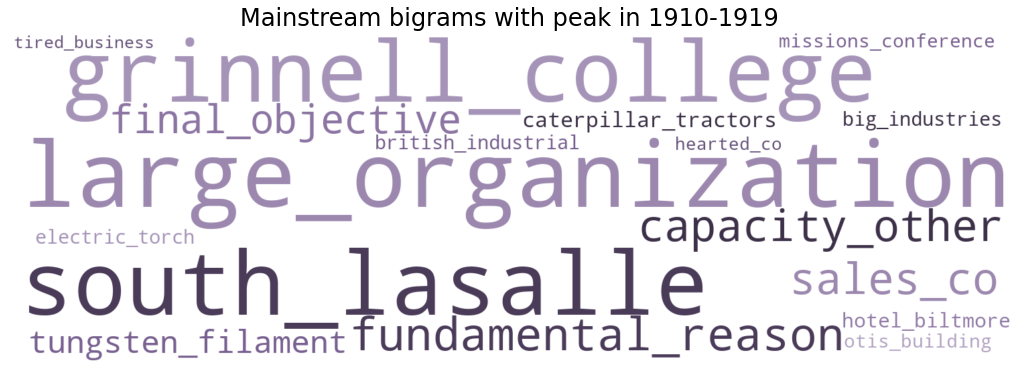

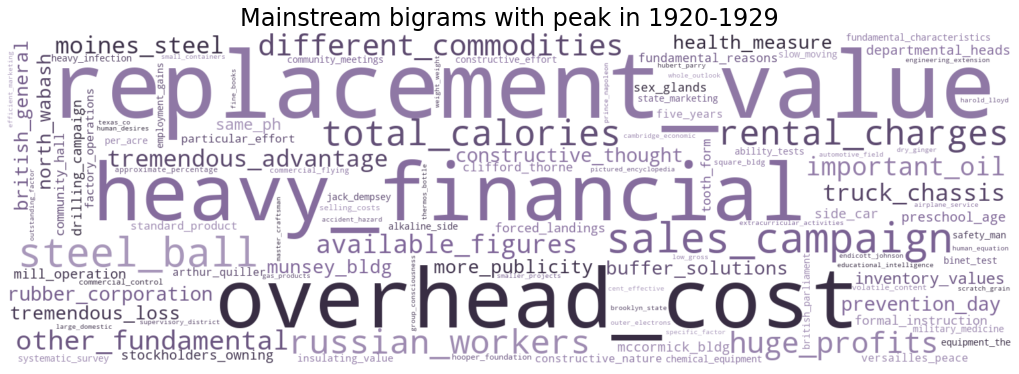

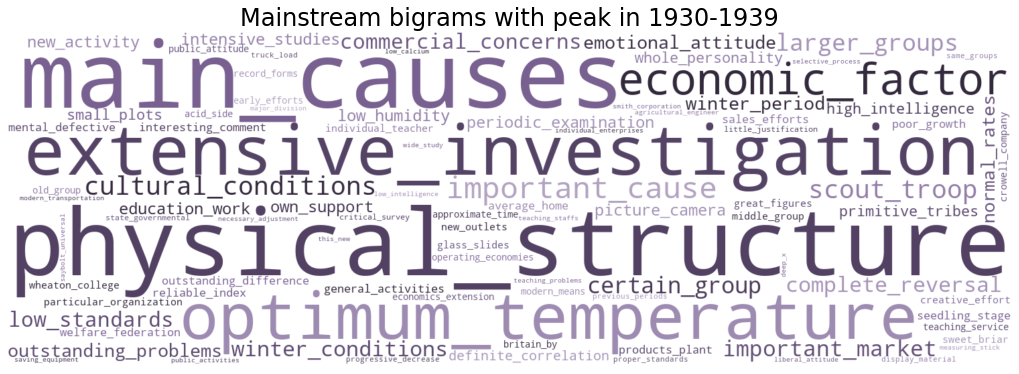

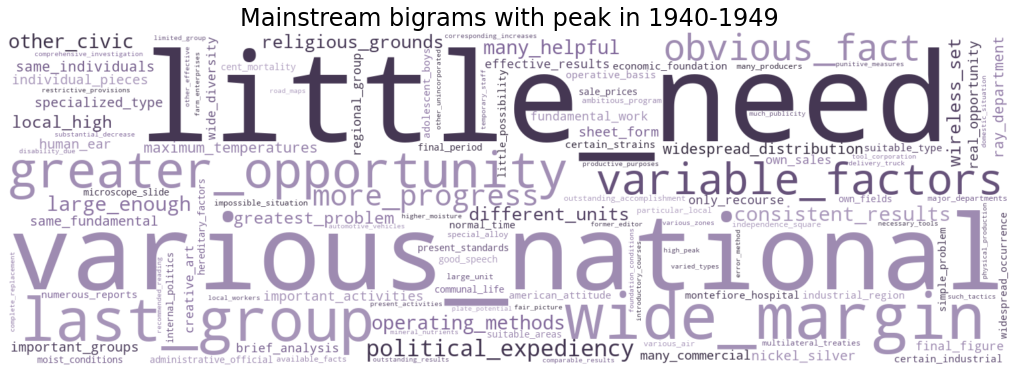

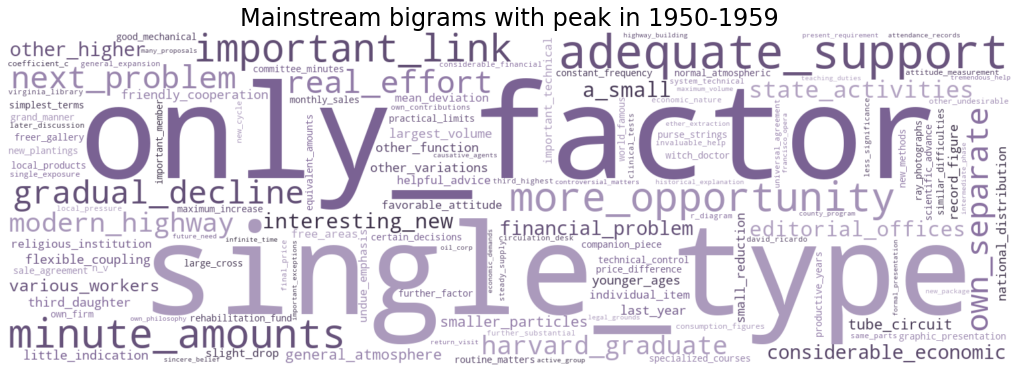

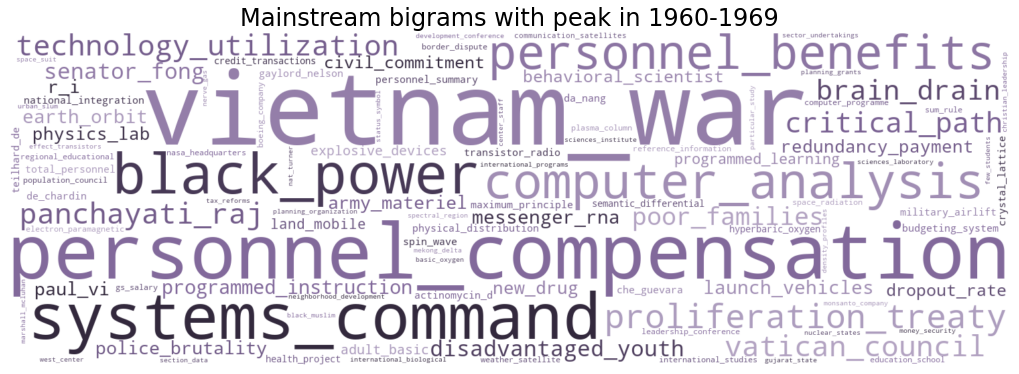

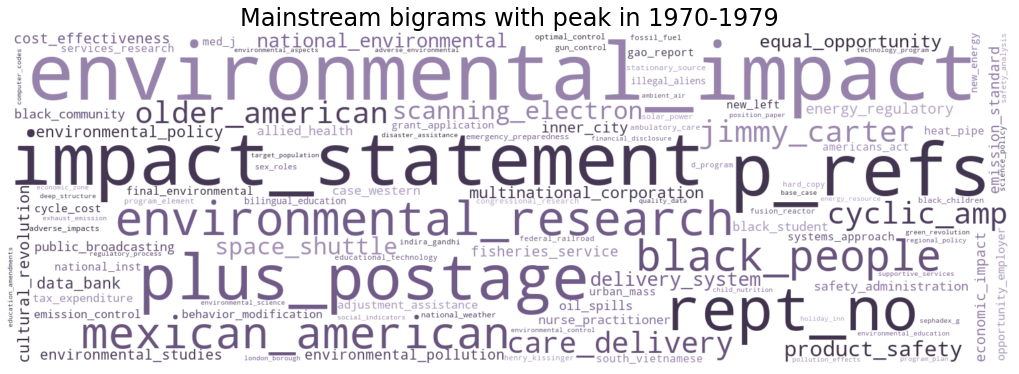

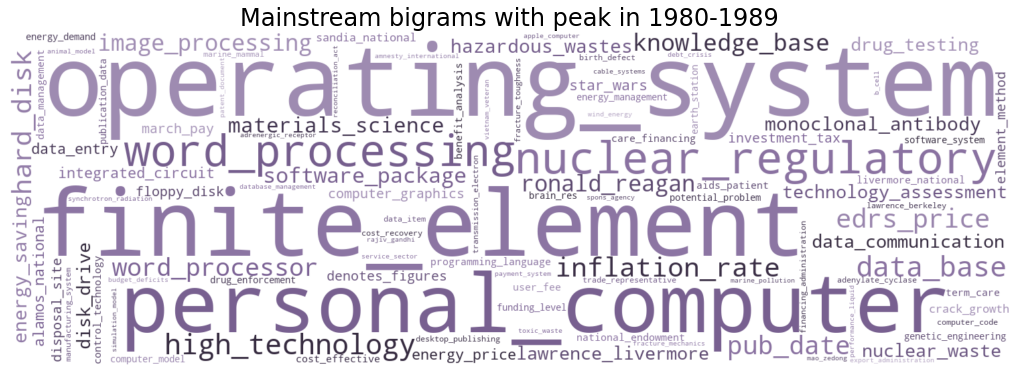

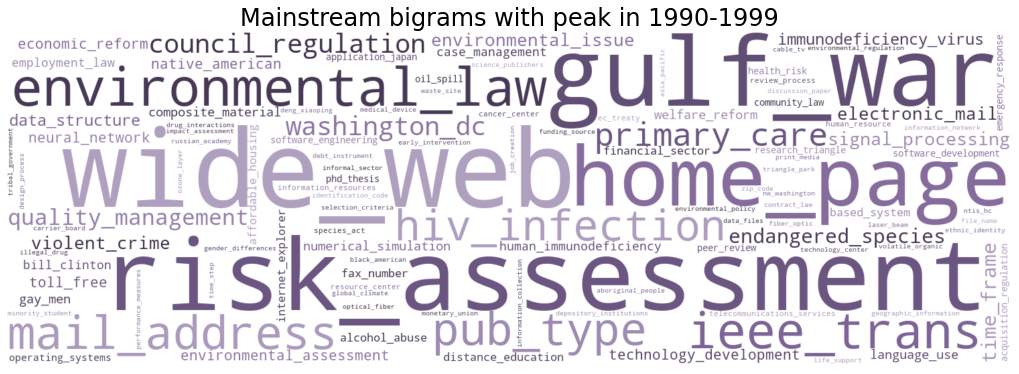

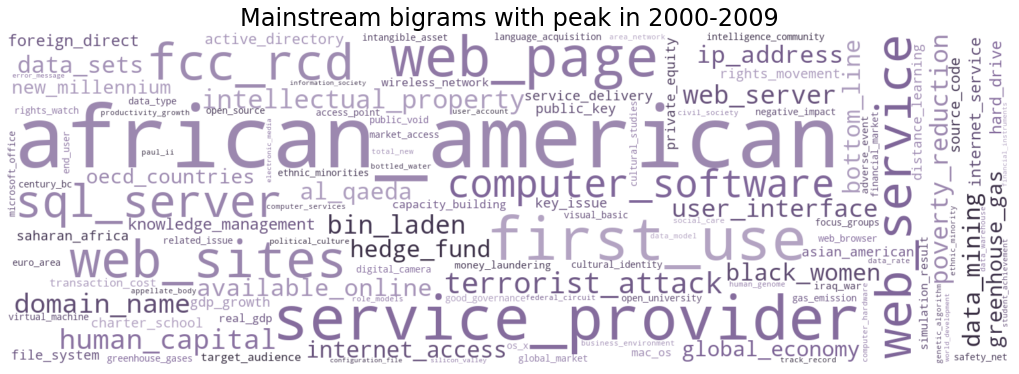

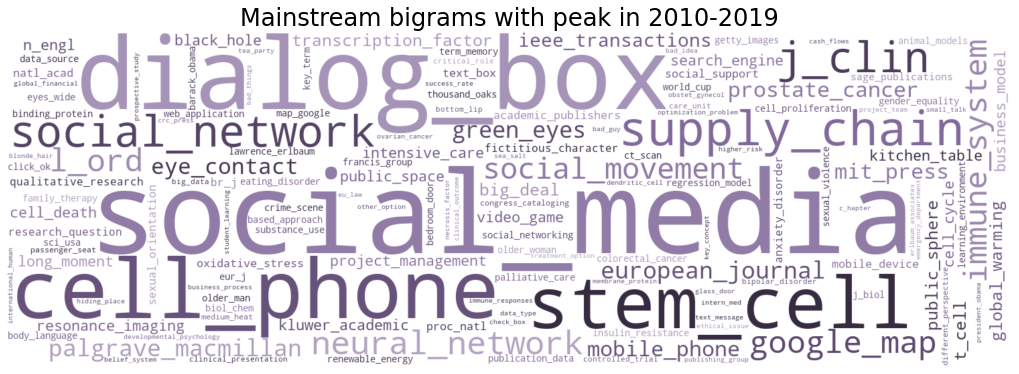

In [42]:
# Wordclouds for decades

for i in range(0,len(wordclouddata3)):
    wordcloud = WordCloud(width = 1500, height = 500, background_color ='white', min_font_size = 10, collocations = False).generate(corpus_new[i])
    # plot the WordCloud image                        
    plt.figure(figsize = (15, 5), facecolor = None)
    plt.title('Mainstream bigrams with peak in ' + names[i], fontsize=24)
    plt.imshow(wordcloud.recolor(color_func=purple_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.savefig('NewDecade'+str(i),bbox_inches='tight')
  
    plt.show() 

### Plot trajectories

In [60]:
def plot_data(model):
    bigrams = model['bigram'].unique()

    for i in range(0, len(bigrams)): 
        tmp = model[model['bigram'] == bigrams[i]]
        tmp = tmp.reset_index()
            
        if tmp.label[i] == 1:
            rpt.display(tmp.bigram_percent.values, [tmp.start_of_mainstreaming[i]-1900, tmp.end_of_mainstreaming[i]-1900, 2020-1900])
            plt.axvline(x=tmp.peak_year[i]-1900, color='salmon', linestyle='--')
            
        plt.title(bigrams[i])
        plt.xlabel('')
        plt.ylabel('')
        x = np.arange(0,121,10)
        xlabels = np.arange(1900,2021,10)
        plt.xticks(x, labels=xlabels)
        plt.savefig('socialmedia')
        plt.show()

In [151]:
verslow = df.where(col('peak_speed') == 'VerySlow').limit(120*10).toPandas()
slow = df.where(col('peak_speed') == 'Slow').limit(120*10).toPandas()
medium = df.where(col('peak_speed') == 'Medium').limit(120*10).toPandas()
fast = df.where(col('peak_speed') == 'Fast').limit(120*10).toPandas()
veryfast = df.where(col('peak_speed') == 'VeryFast').limit(120*10).toPandas()

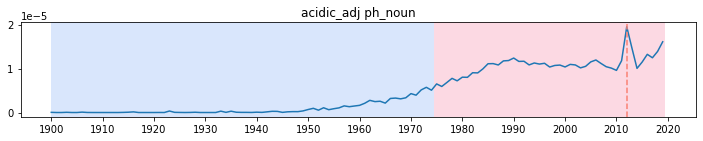

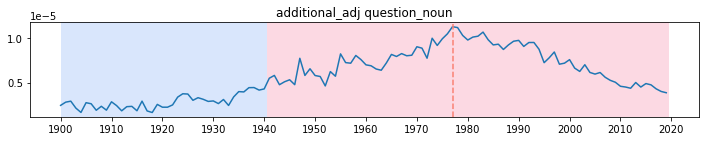

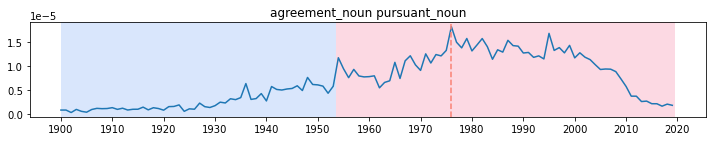

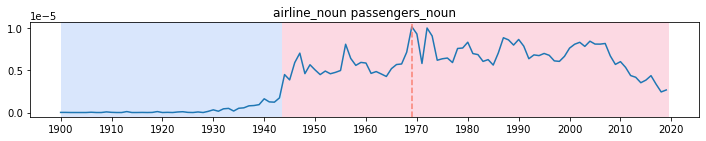

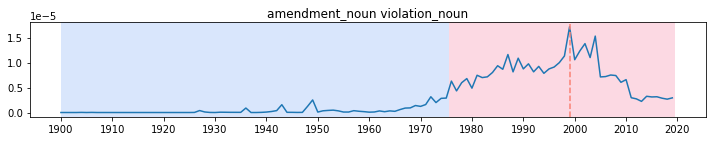

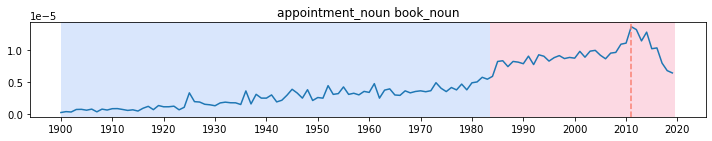

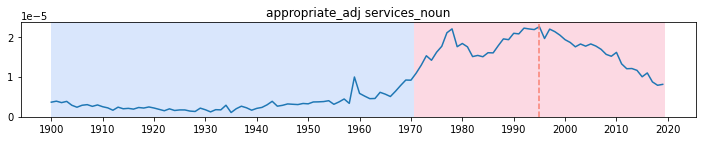

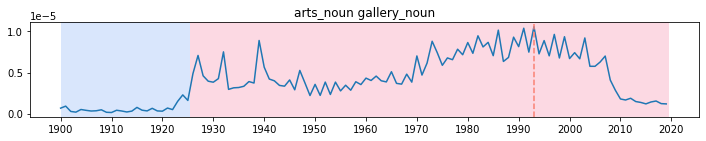

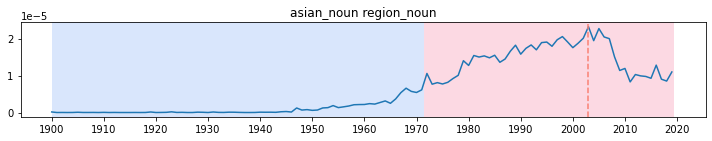

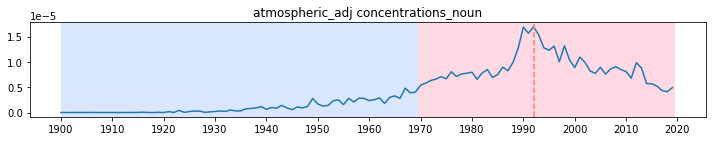

<Figure size 432x288 with 0 Axes>

In [163]:
plot_data(verslow)

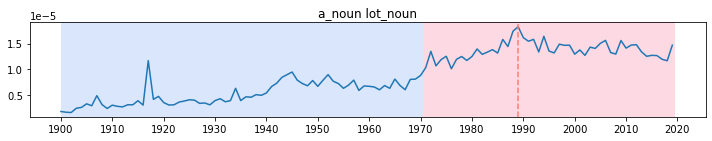

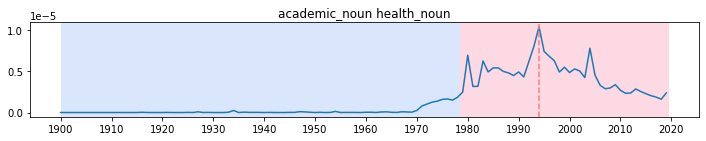

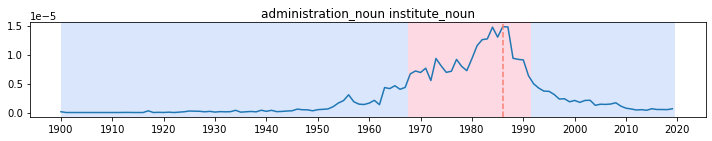

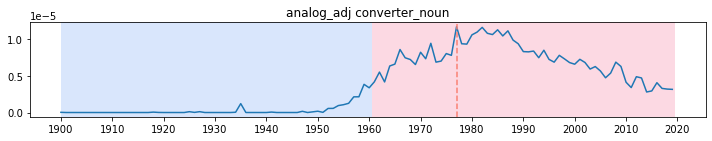

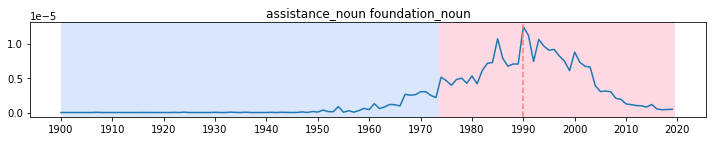

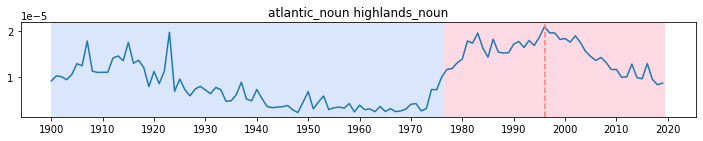

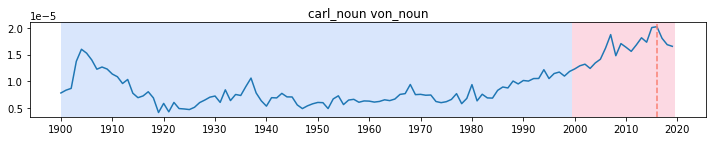

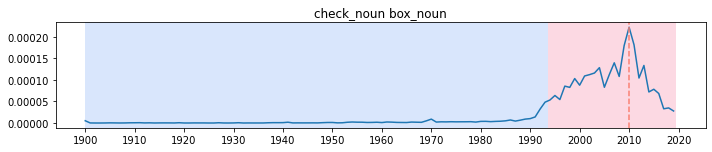

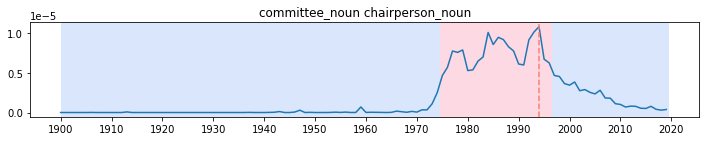

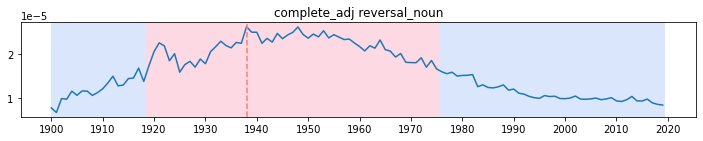

<Figure size 432x288 with 0 Axes>

In [164]:
plot_data(slow)

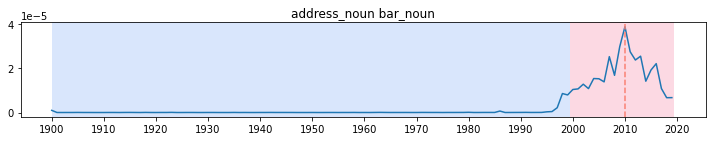

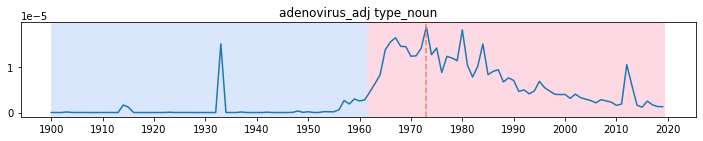

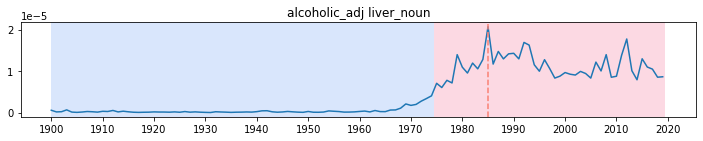

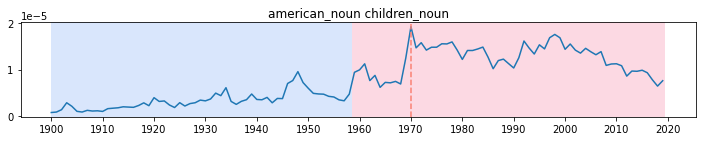

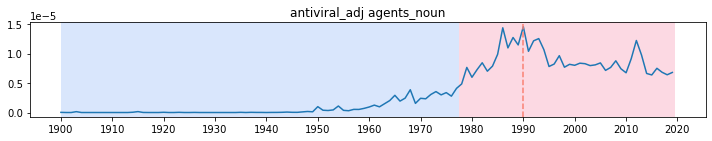

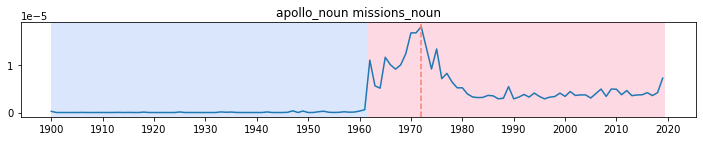

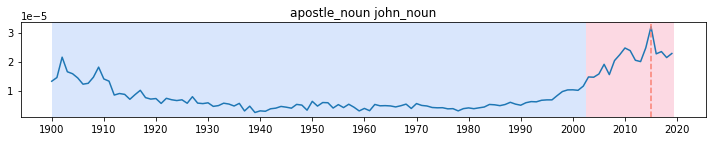

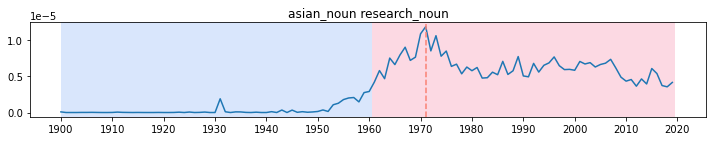

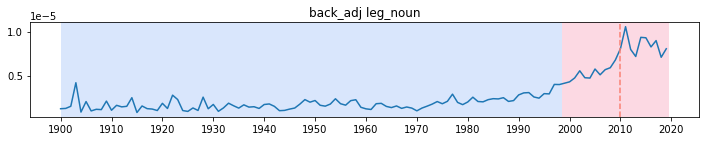

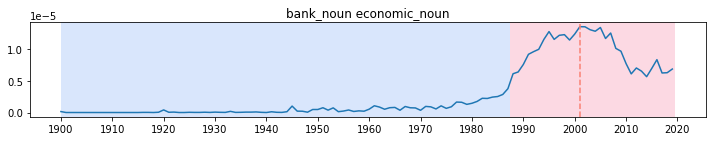

<Figure size 432x288 with 0 Axes>

In [166]:
plot_data(medium)

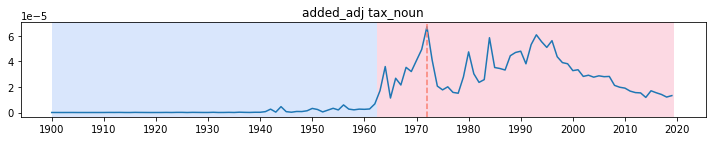

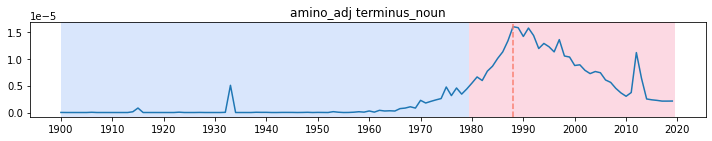

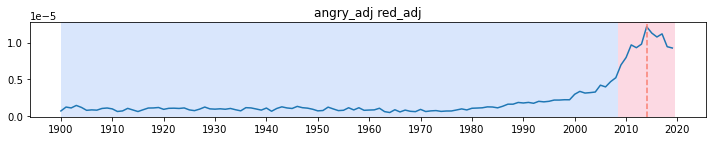

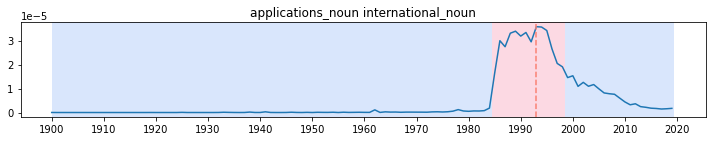

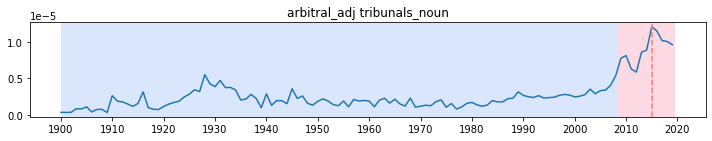

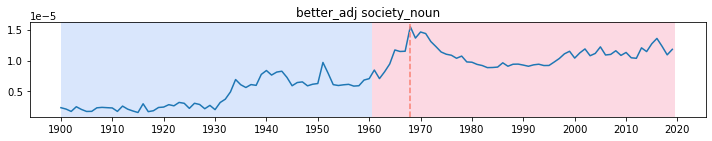

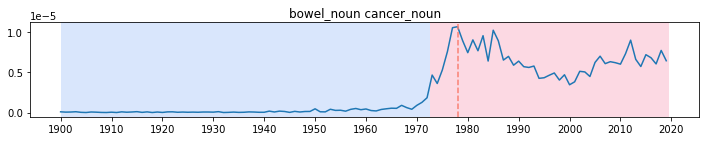

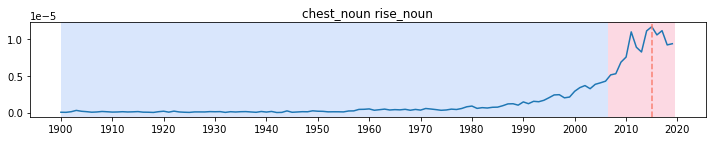

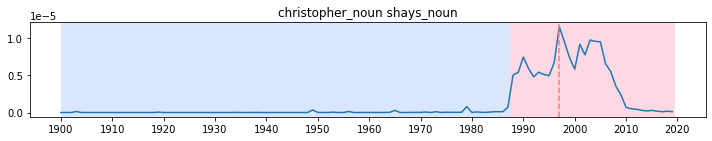

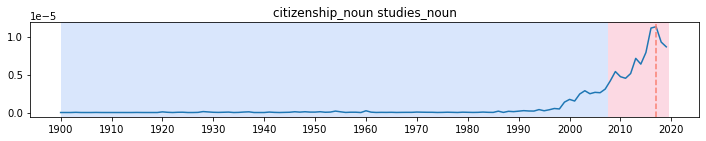

<Figure size 432x288 with 0 Axes>

In [167]:
plot_data(fast)

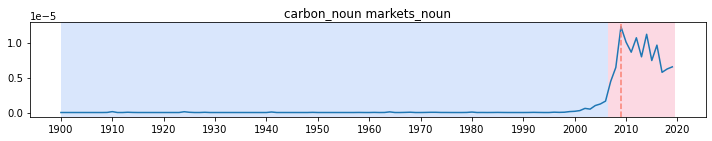

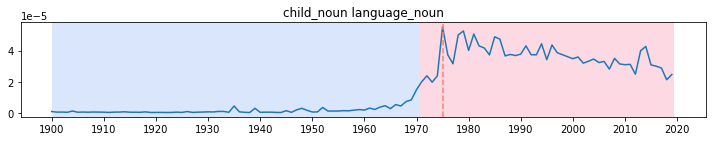

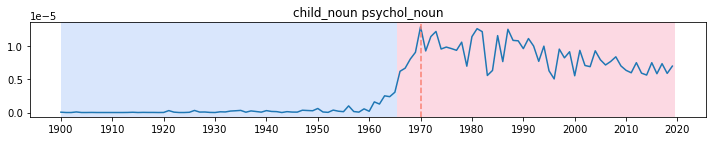

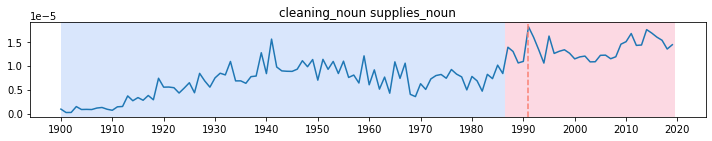

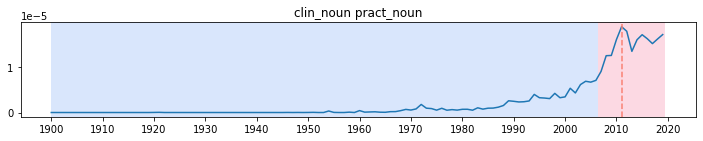

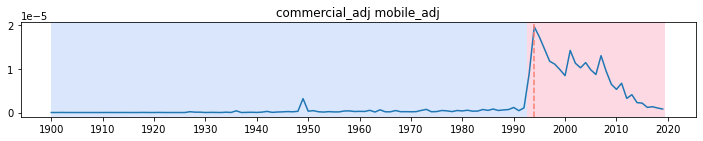

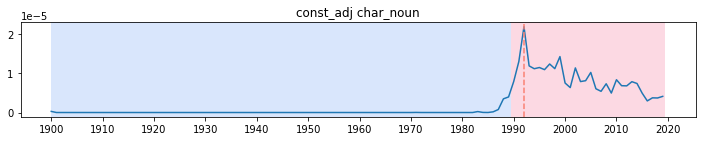

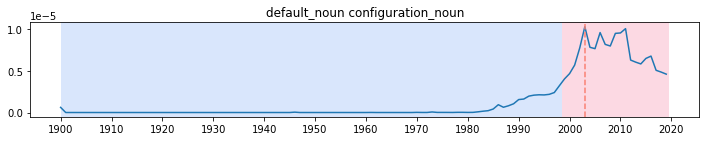

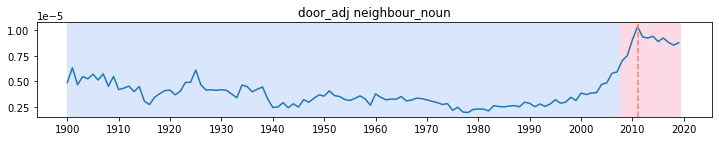

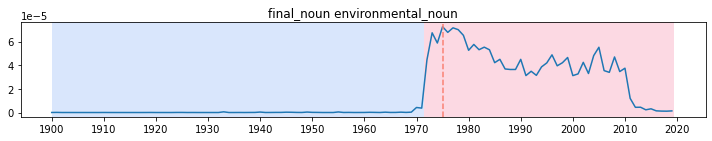

<Figure size 432x288 with 0 Axes>

In [168]:
plot_data(veryfast)

### Plot specific trajectories

In [13]:
plotbigram = df.where((col('bigram') == 'gulf_noun war_noun')).limit(120).toPandas()

In [14]:
plotbigram

bigram  year  count  bigram_percent       medianA  ntileA  \
0    gulf_noun war_noun  1900     48    5.929604e-07  3.603225e-07       8   
1    gulf_noun war_noun  1901      7    8.393796e-08  3.603225e-07       8   
2    gulf_noun war_noun  1902      0    0.000000e+00  3.603225e-07       8   
3    gulf_noun war_noun  1903     14    1.681991e-07  3.603225e-07       8   
4    gulf_noun war_noun  1904      1    1.139452e-08  3.603225e-07       8   
..                  ...   ...    ...             ...           ...     ...   
115  gulf_noun war_noun  2015  36778    1.306555e-04  3.603225e-07       8   
116  gulf_noun war_noun  2016  44510    1.586114e-04  3.603225e-07       8   
117  gulf_noun war_noun  2017  28522    9.861725e-05  3.603225e-07       8   
118  gulf_noun war_noun  2018  28533    1.031790e-04  3.603225e-07       8   
119  gulf_noun war_noun  2019  24741    1.030318e-04  3.603225e-07       8   

      medianB  ntileB  label  start_of_mainstreaming  end_of_mainstreaming  \
0    0.000194      30      1                    1990                  2020   
1    0.000194      30      1                    1990                  2020   
2    0.000194      30      1                    1990                  2020   
3    0.000194      30      1                    1990                  2020   
4    0.000194      30      1                    1990                  2020   
..        ...     ...    ...                     ...                   ...   
115  0.000194      30      1                    1990                  2020   
116  0.000194      30      1                    1990                  2020   
117  0.000194      30      1                    1990                  2020   
118  0.000194      30      1                    1990                  2020   
119  0.000194      30      1                    1990                  2020   

     peak_year  
0         1991  
1         1991  
2         1991  
3         1991  
4         1991  
..         ...  
115       1991  
116       1991  
117       1991  
118       1991  
119       1991  

[120 rows x 12 columns]

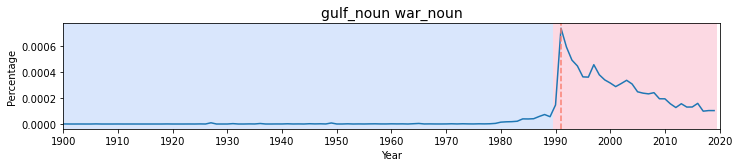

In [16]:
rpt.display(plotbigram.bigram_percent.values, [plotbigram.start_of_mainstreaming[0]-1900, plotbigram.end_of_mainstreaming[0]-1900, 2020-1900])
plt.axvline(x=plotbigram.peak_year[0]-1900, color='salmon', linestyle='--')    
plt.xlabel('')
plt.ylabel('')
x = np.arange(0,121,10)
xlabels = np.arange(1900,2021,10)
plt.xticks(x, labels=xlabels)
plt.xlim([0,120])
plt.title('gulf_noun war_noun', fontsize=14)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Percentage', fontsize=10)
plt.savefig('gulfwar', bbox_inches='tight')
plt.show()

### Pictures to classification section

In [71]:
plot = df_load.where(col('bigram')=='economic_adj damages_noun')
plot1 = df_load.where(col('bigram')=='agricultural_noun superintendent_noun')

In [ ]:
df_load.where(col('bigram')=='adelphi_noun university_noun')

In [50]:
plotbigram = plot.toPandas()

In [72]:
plotbigram2 = plot1.toPandas()

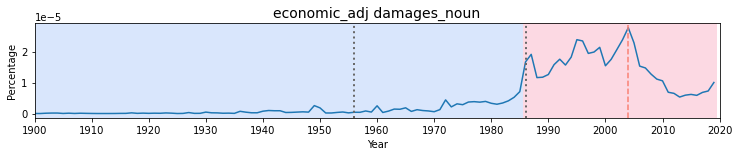

In [77]:
rpt.display(plotbigram.bigram_percent.values, [plotbigram.start_of_mainstreaming[0]-1900, plotbigram.end_of_mainstreaming[0]-1900, 2020-1900])
plt.axvline(x=plotbigram.peak_year[0]-1900, color='salmon', linestyle='--')    
plt.axvline(x=1986-1900, color='dimgrey', linestyle='dotted', linewidth=2)
plt.axvline(x=1986-1900-30, color='dimgrey', linestyle='dotted', linewidth=2)
#plt.figure(figsize=(12.2,1.8))
#plt.plot(plotbigram.bigram_percent.values)
#plt.plot(plotbigram2.bigram_percent.values)
#plt.legend(['adelphi noun university noun','adelphi noun college noun'])
plt.xlabel('')
plt.ylabel('')
x = np.arange(0,121,10)
xlabels = np.arange(1900,2021,10)
plt.xticks(x, labels=xlabels)
plt.xlim([0,120])
plt.title('economic_adj damages_noun', fontsize=14)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Percentage', fontsize=10)
plt.savefig('economic_damages', bbox_inches='tight')
plt.show()

In [9]:
df = df.where((col('bigram') == 'african_noun american_noun') | (col('bigram') == 'african_adj american_adj') | (col('bigram') == 'african_noun americans_noun'))